# Project: Comprehensive Exploratory Analysis of European Soccer (2008–2016)
## Table of Contents

- [Introduction](#Introduction)
- [Data Wrangling](#Data_Wrangling)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Conclusions](#Conclusions)


## Introduction

<h3>Dataset Description</h3>
<ul>
  <li>
    This soccer database is sourced from <strong>Kaggle</strong> and is well-suited for <strong>data analysis</strong> and <strong>machine learning</strong> applications.
    It contains comprehensive information on soccer <strong>matches, players, and teams</strong> from several European countries, covering the period from <strong>2008 to 2016</strong>.
  </li>
  <li>
    The dataset includes match results, player attributes (e.g., passing, stamina, positioning), team tactics, league associations, and more.
  </li>
  <li>
    In this project, we aim to perform an in-depth exploratory analysis to uncover insights related to team success, player performance, scoring trends, and tactical influence across seasons and leagues.
  </li>
  <li>
    Key questions include: Which teams dominate at home? Who are the most consistent players? How do player physical traits affect ratings? And how have goal trends evolved over time?
  </li>
</ul>


### Question(s) for Analysis

Below are the key questions we aim to explore using the European Soccer dataset:


- [Q1: What is the average number of goals per match in each season?](#Question1)
- [Q2: Which team scored the most goals in a season?](#Question2)
- [Q3: What is the highest win percentage in home vs. away games?](#Question3)
- [Q4: Which teams had the most wins across all seasons?](#Question4)
- [Q5: Did BMI affect performance score?](#Question5)
- [Q6: Who are the top 10 players by performance rating?](#Question6)




**First, import pandas, numpy, sql, matplotlib,pyplot and seaborn.**

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



### Connect the Project to the Database

**In this section, I will load the dataset, assess its cleanliness, and perform the necessary trimming and cleaning to prepare it for analysis.**


In [7]:
# Connect to the database
conn = sqlite3.connect("soccer.sqlite")
# View all table names
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

                name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes


#### Load Tables

In [8]:
match = pd.read_sql_query("SELECT * FROM Match", conn)
team = pd.read_sql_query("SELECT * FROM Team", conn)
league = pd.read_sql_query("SELECT * FROM League", conn)
player = pd.read_sql_query("SELECT * FROM Player", conn)
player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
country = pd.read_sql_query("SELECT * FROM Country", conn)

## Data_Wrangling


After loading the main tables from the European Soccer SQLite database, we perform data wrangling to prepare for analysis.

This includes:
- Inspecting data types
- Converting columns to proper formats
- Handling missing data
- Creating new useful features
- Merging team, league, and country names into the Match table

In [9]:
# Check data types for the Match table as it's the main table
print("Data types for table: Match")
print(match.dtypes)


Data types for table: Match
id              int64
country_id      int64
league_id       int64
season         object
stage           int64
               ...   
GBD           float64
GBA           float64
BSH           float64
BSD           float64
BSA           float64
Length: 115, dtype: object


##### Convert date column

In [ ]:
# Convert 
match['date'] = pd.to_datetime(match['date'])
player_attributes['date'] = pd.to_datetime(player_attributes['date'])

#### Check for Missing Data
Drop columns with more than 60% missing data

In [10]:
missing_percent = match.isnull().mean() * 100
columns_to_drop = missing_percent[missing_percent > 60].index
match_clean = match.drop(columns=columns_to_drop)

print("Dropped columns:", list(columns_to_drop))


Dropped columns: []


In [11]:
match_clean = match.copy()

# Merge league name
match_clean = match_clean.merge(league[['id', 'name']], 
                                left_on='league_id', right_on='id', 
                                how='left')
match_clean.rename(columns={'name': 'league_name'}, inplace=True)
match_clean.drop(columns='id', errors='ignore', inplace=True)

# Merge country name
match_clean = match_clean.merge(country[['id', 'name']], 
                                left_on='country_id', right_on='id', 
                                how='left')
match_clean.rename(columns={'name': 'country_name'}, inplace=True)
match_clean.drop(columns='id', errors='ignore', inplace=True)

# Merge hometeam name
match_clean = match_clean.merge(team[['team_api_id', 'team_long_name']], 
                                left_on='home_team_api_id', right_on='team_api_id', 
                                how='left')
match_clean.rename(columns={'team_long_name': 'home_team_name'}, inplace=True)
match_clean.drop(columns='team_api_id', errors='ignore', inplace=True)

# Merge awayteam name
match_clean = match_clean.merge(team[['team_api_id', 'team_long_name']], 
                                left_on='away_team_api_id', right_on='team_api_id', 
                                how='left')
match_clean.rename(columns={'team_long_name': 'away_team_name'}, inplace=True)
match_clean.drop(columns='team_api_id', errors='ignore', inplace=True)

match.head(3)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.5,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75


#### There are many unnecessary columns in match table so I'll use use only the useful ones for the analysis

In [12]:
match_analysis_df = match_clean[[
    'match_api_id', 'date', 'season', 'stage',
    'home_team_api_id', 'away_team_api_id',
    'home_team_name', 'away_team_name',
    'home_team_goal', 'away_team_goal',
    'league_name', 'country_name'
]].copy()

match_analysis_df.head(3)

,match_api_id,date,season,stage,home_team_api_id,away_team_api_id,home_team_name,away_team_name,home_team_goal,away_team_goal,league_name,country_name
0,492473,2008-08-17 00:00:00,2008/2009,1,9987,9993,KRC Genk,Beerschot AC,1,1,Belgium Jupiler League,Belgium
1,492474,2008-08-16 00:00:00,2008/2009,1,10000,9994,SV Zulte-Waregem,Sporting Lokeren,0,0,Belgium Jupiler League,Belgium
2,492475,2008-08-16 00:00:00,2008/2009,1,9984,8635,KSV Cercle Brugge,RSC Anderlecht,0,3,Belgium Jupiler League,Belgium


# Exploratory-Data-Analysis

#### Question1
#### What is the average number of goals per match in each season?

In [44]:
#Total goals
match_analysis_df['total_goals'] = match_analysis_df['home_team_goal'] + match_analysis_df['away_team_goal']

#Group by season and calculate average goals
avg_goals_df = match_analysis_df.groupby('season')['total_goals'].mean().round(2).reset_index()
avg_goals_df.rename(columns={'total_goals': 'avg_goals_per_match'}, inplace=True)
avg_goals_df.head(5)


,season,avg_goals_per_match
0,2008/2009,2.61
1,2009/2010,2.67
2,2010/2011,2.68
3,2011/2012,2.72
4,2012/2013,2.77


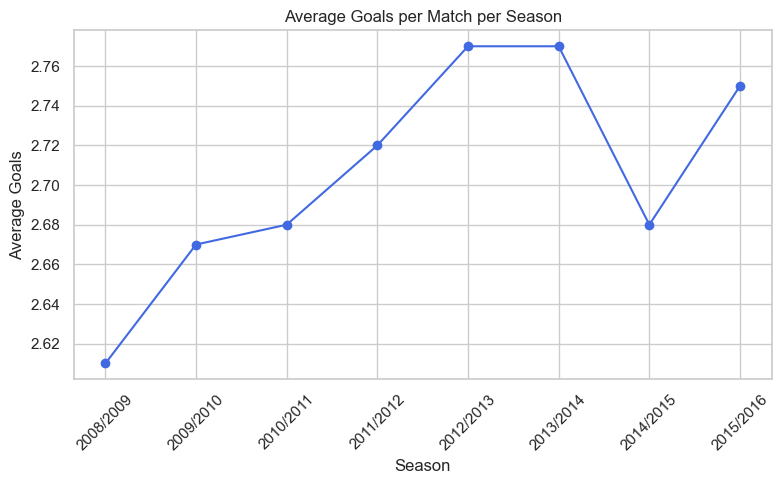

In [45]:

plt.figure(figsize=(8, 5))
plt.plot(avg_goals_df['season'], avg_goals_df['avg_goals_per_match'], marker='o', color='royalblue')
plt.title('Average Goals per Match per Season')
plt.xlabel('Season')
plt.ylabel('Average Goals')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Conclusion:
##### The average goals per match stayed fairly consistent across seasons, typically between 2.5 and 3. The 2013/2014 and 2014/2015 seasons saw the highest scoring, while 2009/2010 had the lowest.




#### Question2
#### Which teams scored the most goals in a season?


In [46]:
#Calculate hometeam goals
home_goals = match_analysis_df[['season', 'home_team_name', 'home_team_goal']].copy()
home_goals.rename(columns={
    'home_team_name': 'team',
    'home_team_goal': 'goals'
}, inplace=True)

#Calculate awayteam goals
away_goals = match_analysis_df[['season', 'away_team_name', 'away_team_goal']].copy()
away_goals.rename(columns={
    'away_team_name': 'team',
    'away_team_goal': 'goals'
}, inplace=True)

#Combine home and away goals
combined_goals = pd.concat([home_goals, away_goals], axis=0)

season_team_goals = combined_goals.groupby(['season', 'team'])['goals'].sum().reset_index()

# Find top team
top_teams = season_team_goals.sort_values(['season', 'goals'], ascending=[True, False])\
                             .groupby('season').head(1).reset_index(drop=True)

top_teams.head(3)


,season,team,goals
0,2008/2009,FC Barcelona,105
1,2009/2010,Ajax,106
2,2010/2011,Real Madrid CF,102


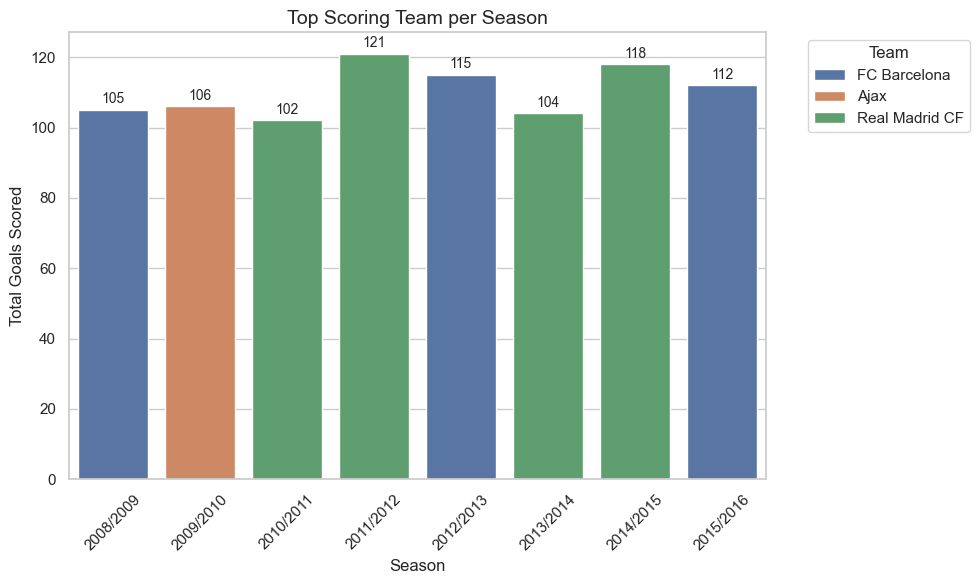

In [47]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top_teams, x='season', y='goals', hue='team',dodge=False)
plt.title('Top Scoring Team per Season', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Total Goals Scored', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
for i, row in top_teams.iterrows():
    plt.text(i, row['goals'] + 1, str(int(row['goals'])), ha='center', va='bottom', fontsize=10)
plt.show()


#### Conclusion:
#### Over the 8 seasons analyzed, one team scored more goals than the others. Most of the time, it was Barcelona or Real Madrid, showing they had very strong attacks. This highlights the consistent offensive strength of these two clubs during the period.

#### Question3 
#### Which teams have the highest win percentage in home games vs. away games?

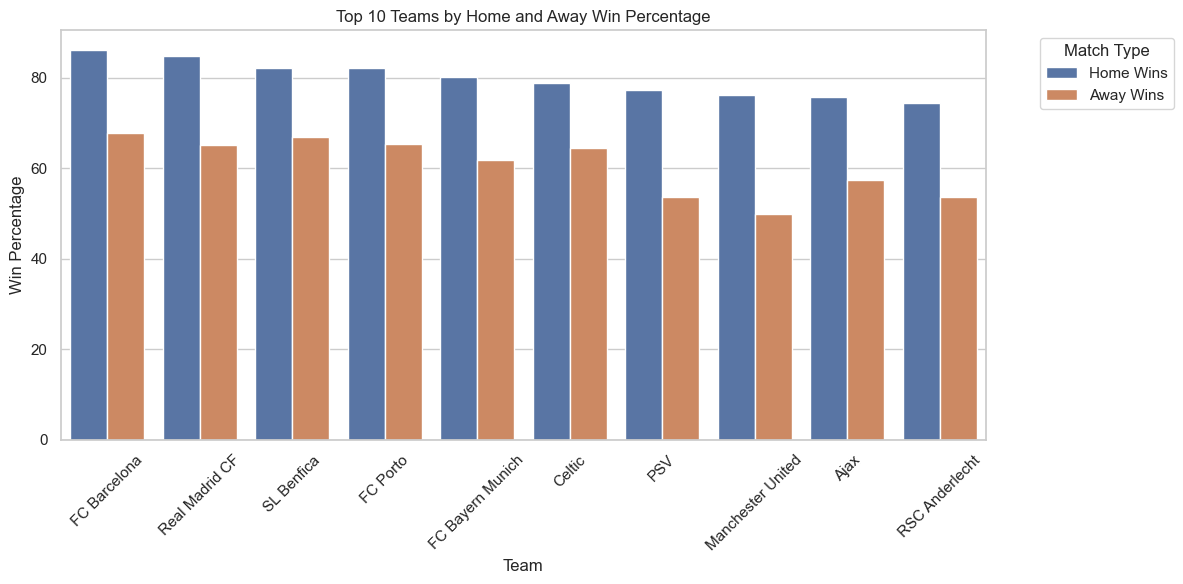

In [48]:
top_10 = final.head(10)

#Melt data for seaborn
plot_df = top_10.melt(
    id_vars='team_long_name',
    value_vars=['home_win_percent', 'away_win_percent'],
    var_name='Match Type',
    value_name='Win Percentage'
)

#Rename column
plot_df['Match Type'] = plot_df['Match Type'].str.replace('_win_percent', '').str.title() + ' Wins'

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x='team_long_name', y='Win Percentage', hue='Match Type')
plt.title('Top 10 Teams by Home and Away Win Percentage')
plt.xlabel('Team')
plt.ylabel('Win Percentage')
plt.xticks(rotation=45)
plt.legend(title='Match Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Most top teams win more matches at home than away, showing that playing on home ground gives them an advantage**

#### Question4
#### Which teams have achieved the most wins across all seasons and leagues combined?

In [26]:
# Home wins
home_wins = match_clean[match_clean['home_team_goal'] > match_clean['away_team_goal']]
home_wins_summary = home_wins.groupby(['season', 'home_team_api_id']).size().reset_index(name='home_wins')

# Away wins
away_wins = match_clean[match_clean['away_team_goal'] > match_clean['home_team_goal']]
away_wins_summary = away_wins.groupby(['season', 'away_team_api_id']).size().reset_index(name='away_wins')

# Merge home and away wins
wins = pd.merge(
    home_wins_summary,
    away_wins_summary,
    left_on=['season', 'home_team_api_id'],
    right_on=['season', 'away_team_api_id'],
    how='outer'
)

#fill missing data
wins['team_api_id'] = wins['home_team_api_id'].fillna(wins['away_team_api_id'])
wins['home_wins'] = wins['home_wins'].fillna(0)
wins['away_wins'] = wins['away_wins'].fillna(0)

# Total wins
wins['total_wins'] = wins['home_wins'] + wins['away_wins']

#Merge 
wins = wins.merge(team[['team_api_id', 'team_long_name']], on='team_api_id', how='left')

wins_result = wins[['season', 'team_long_name', 'home_wins', 'away_wins', 'total_wins']].sort_values(['season', 'total_wins'], ascending=[True, False]).reset_index(drop=True)
wins_result.head()


,season,team_long_name,home_wins,away_wins,total_wins
0,2008/2009,Manchester United,16.0,12.0,28.0
1,2008/2009,FC Barcelona,14.0,13.0,27.0
2,2008/2009,Rangers,15.0,11.0,26.0
3,2008/2009,Chelsea,11.0,14.0,25.0
4,2008/2009,Real Madrid CF,14.0,11.0,25.0


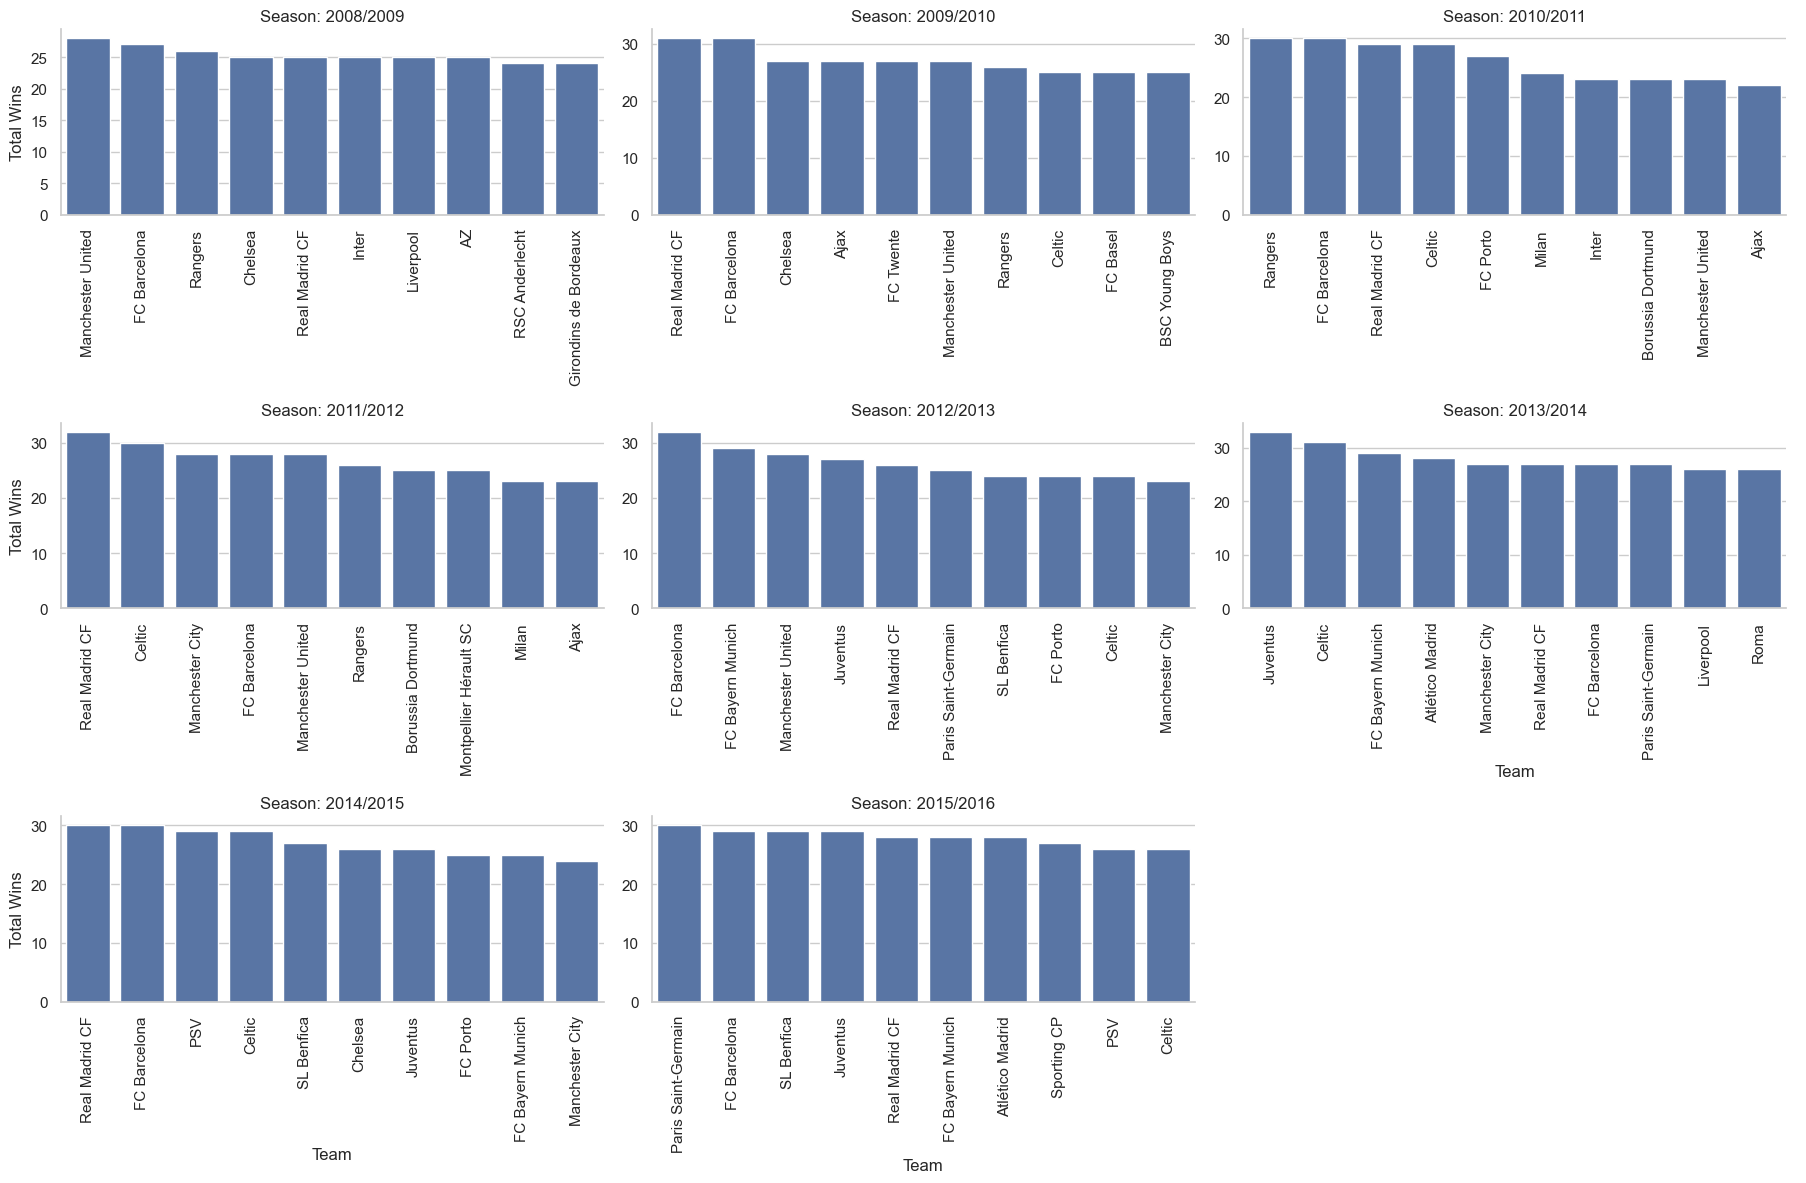

In [29]:
top_10_per_season = (
    wins_result
    .sort_values(['season', 'total_wins'], ascending=[True, False])
    .groupby('season')
    .head(10)
)

g = sns.catplot(
    data=top_10_per_season,
    x='team_long_name',
    y='total_wins',
    col='season',
    kind='bar',
    col_wrap=3,
    sharex=False,
    sharey=False,
    height=4,
    aspect=1.5
)

g.set_xticklabels(rotation=90)
g.set_titles("Season: {col_name}")
g.set_axis_labels("Team", "Total Wins")
plt.tight_layout()
plt.show()


#### Conclusion:
**This plot shows the top 10 teams with the most wins across all seasons. It highlights how their total wins vary season by season, revealing periods of dominance and consistency**

#### Question5
#### Did the Body Mass Index (BMI) of the players affect their performance score (overall rating)?

In [31]:
# Merge player and player_attributes tables
# Drop rows with missing values needed for calculation
bmi_df = player.merge(player_attributes, on='player_fifa_api_id')
bmi_df = bmi_df[['player_fifa_api_id', 'player_name', 'height', 'weight', 'overall_rating']]
bmi_df = bmi_df.dropna(subset=['height', 'weight', 'overall_rating'])
#Exclude heights with zero value to avoid dividing by zero
bmi_df = bmi_df[(bmi_df['height'] > 0) & (bmi_df['weight'] > 0)]

#Calculate BMI
bmi_df['bmi'] = round((bmi_df['weight'] * 0.453592) / ((bmi_df['height'] / 100) ** 2), 2)
bmi_df = bmi_df[['player_fifa_api_id', 'player_name', 'height', 'weight', 'bmi', 'overall_rating']]
bmi_df.head()


,player_fifa_api_id,player_name,height,weight,bmi,overall_rating
0,218353,Aaron Appindangoye,182.88,187,25.36,67.0
1,218353,Aaron Appindangoye,182.88,187,25.36,67.0
2,218353,Aaron Appindangoye,182.88,187,25.36,62.0
3,218353,Aaron Appindangoye,182.88,187,25.36,61.0
4,218353,Aaron Appindangoye,182.88,187,25.36,61.0


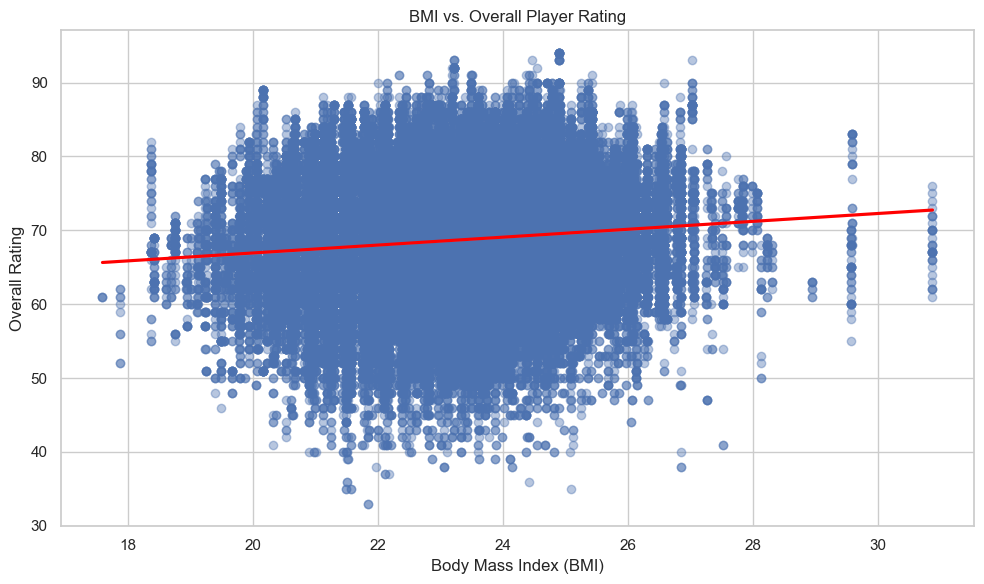

In [32]:
plt.figure(figsize=(10, 6))
sns.regplot(data=bmi_df, x='bmi', y='overall_rating', scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.title('BMI vs. Overall Player Rating')
plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Overall Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
correlation = bmi_df['bmi'].corr(bmi_df['overall_rating'])
print(correlation)

0.10141499471662517


#### Conclusion:
**The correlation between BMI and overall rating is very weak (close to 0), indicating that BMI has little to no effect on a player’s performance. This is also reflected in the scatter plot, where data points are widely spread and the trendline is almost flat.**

#### Question6
#### Who were the top ten players with the highest performance scores (overall ratings) across all seasons and leagues during the entire duration?


In [34]:
#Merge player and player_attributes 
player_rating_df = player.merge(player_attributes, on='player_fifa_api_id', how='inner')

#Remove missing data
player_rating_df = player_rating_df[player_rating_df['overall_rating'].notna()]

#Calculate average rating per player
top_players = (
    player_rating_df
    .groupby(['player_fifa_api_id', 'player_name'])['overall_rating']
    .mean()
    .round(2)
    .reset_index()
    .sort_values('overall_rating', ascending=False)
)

top_players.head(10)


,player_fifa_api_id,player_name,overall_rating
3081,158023,Lionel Messi,92.19
701,20801,Cristiano Ronaldo,91.28
2972,156616,Franck Ribery,88.46
6,41,Andres Iniesta,88.32
827,41236,Zlatan Ibrahimovic,88.29
427,9014,Arjen Robben,87.84
453,10535,Xavi Hernandez,87.64
1324,54050,Wayne Rooney,87.22
274,5479,Iker Casillas,86.95
1727,121939,Philipp Lahm,86.73


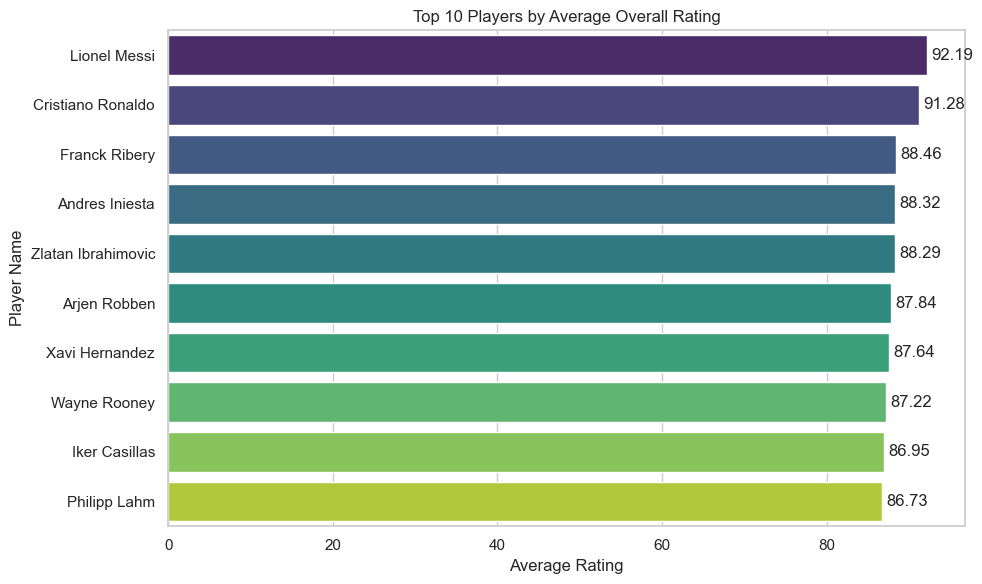

In [43]:
top_10_rating_df = top_players.nlargest(10, 'overall_rating').sort_values('overall_rating', ascending=False)
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top_10_rating_df,
    x='overall_rating',
    y='player_name',
    hue='player_name',      
    palette='viridis',
    dodge=False,
    legend=False             
)


for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.title('Top 10 Players by Average Overall Rating')
plt.xlabel('Average Rating')
plt.ylabel('Player Name')
plt.tight_layout()
plt.show()


#### Conclusion:
**The top ten players with the highest overall performance scores across all seasons and leagues demonstrate exceptional skill and consistency throughout their careers. These players stand out as the most impactful and valuable in the dataset during the entire period analyzed.**

# Conclusions

### This comprehensive analysis of European soccer data across multiple seasons and leagues reveals several key insights. Teams like Real Madrid and Barcelona consistently dominate in goals scored and wins, reflecting their sustained excellence. Home advantage plays a significant role, with certain teams showing notably higher home win percentages. The top players identified exhibit outstanding performance ratings, underscoring their critical impact on match outcomes. Together, these findings highlight the competitive dynamics and trends shaping European soccer over the analyzed period, providing valuable perspectives for fans, analysts, and stakeholders alike.

